#Binary AskQE Extension  
Pipeline: SRL / OpenIE / Dependency /NER

#Git

In [42]:
!git config --global user.email "erfan.alerom@gmail.com"
!git config --global user.name "erythm"

In [43]:
!cp '/content/drive/MyDrive/Colab Notebooks/extention.ipynb' /content/askqe/

In [46]:
!git add extention.ipynb

In [48]:
!git commit -m "Implement hybrid binary QA extension with improved metrics"

[main 34f0429] Implement hybrid binary QA extension with improved metrics
 1 file changed, 1 insertion(+), 1 deletion(-)


In [94]:
!git remote set-url origin https://@github.com/erythm/askqe.git
!git push origin main

Enumerating objects: 30, done.
Counting objects: 100% (30/30), done.
Delta compression using up to 2 threads
Compressing objects: 100% (19/19), done.
Writing objects: 100% (20/20), 330.94 KiB | 2.04 MiB/s, done.
Total 20 (delta 8), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (8/8), completed with 7 local objects.
To https://github.com/erythm/askqe.git
   f09f9fb..e611acf  main -> main


# Requirments

In [1]:
!git clone https://github.com/erythm/askqe.git

Cloning into 'askqe'...
remote: Enumerating objects: 1142, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1142 (delta 18), reused 19 (delta 7), pack-reused 1102 (from 2)
Receiving objects: 100% (1142/1142), 52.81 MiB | 9.76 MiB/s, done.
Resolving deltas: 100% (890/890), done.
Updating files: 100% (1043/1043), done.


In [45]:
%cd askqe

/content/askqe


In [95]:
%cd ..

/content


In [2]:
!pip install -q vllm transformers accelerate
!pip install -q spacy
!python -m spacy download en_core_web_sm

print("libraries installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.9/474.9 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 

In [3]:
import json
import os
import re
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, spearmanr
from tqdm import tqdm

print("✅ Imports done!")

✅ Imports done!


#Repository Imports

In [4]:
import sys
import os
import importlib.util

REPO_PATH = "askqe"

# Add repository paths to Python path
sys.path.insert(0, REPO_PATH)
sys.path.insert(0, f"{REPO_PATH}/QG/code")
sys.path.insert(0, f"{REPO_PATH}/QA/code")
sys.path.insert(0, f"{REPO_PATH}/biomqm/askqe")
sys.path.insert(0, f"{REPO_PATH}/evaluation/string-comparison")

# --- Import Prompts from Repository ---
from QG.code.prompt import nli as qg_nli_prompt
from QG.code.prompt import vanilla as qg_vanilla_prompt
from QG.code.prompt import prompts as qg_prompts

from QA.code.prompt import qa_prompt

from biomqm.askqe.prompt import atomic_fact_prompt
from biomqm.askqe.prompt import nli as biomqm_nli_prompt

# --- Import utils using importlib ---
utils_path = f"{REPO_PATH}/evaluation/string-comparison/utils.py"
spec = importlib.util.spec_from_file_location("utils_module", utils_path)
utils_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils_module)

# Assign functions
repo_f1_score = utils_module.f1_score
repo_exact_match_score = utils_module.exact_match_score
repo_chrf_score = utils_module.chrf_score
repo_bleu_score = utils_module.bleu_score
repo_compare_answers = utils_module.compare_answers
normalize_answer = utils_module.normalize_answer

print("✅ Repository imports loaded successfully!")
print(f"   - QG prompts: vanilla, nli, srl")
print(f"   - QA prompt: qa_prompt")
print(f"   - Atomic fact prompt: atomic_fact_prompt")
print(f"   - Scoring functions: f1_score, exact_match_score, chrf_score, bleu_score")

atomic_fact_prompt_template = atomic_fact_prompt
qg_prompt_template = qg_nli_prompt
qa_prompt_template = qa_prompt

print("\n✅ Prompt templates configured:")
print(f"   atomic_fact_prompt_template = biomqm/askqe/prompt.py::atomic_fact_prompt")
print(f"   qg_prompt_template = QG/code/prompt.py::nli (best config per paper)")
print(f"   qa_prompt_template = QA/code/prompt.py::qa_prompt")

ModuleNotFoundError: No module named 'sacrebleu'

## Load Qwen2.5-7B Model with vLLM

In [5]:
from vllm import LLM, SamplingParams

MODEL_ID = "Qwen/Qwen2.5-7B-Instruct-AWQ"

print(f"Loading {MODEL_ID}...")

llm = LLM(
    model=MODEL_ID,
    quantization="awq",
    dtype="half",
    max_model_len=4096,
    gpu_memory_utilization=0.85,
)

SAMPLING_PARAMS = SamplingParams(
    temperature=0.1,
    top_p=0.95,
    max_tokens=512,
    stop=["<|endoftext|>", "<|im_end|>"]
)

print("LLM loaded!")

Loading Qwen/Qwen2.5-7B-Instruct-AWQ...
INFO 12-27 17:54:25 [utils.py:253] non-default args: {'dtype': 'half', 'max_model_len': 4096, 'gpu_memory_utilization': 0.85, 'disable_log_stats': True, 'quantization': 'awq', 'model': 'Qwen/Qwen2.5-7B-Instruct-AWQ'}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

INFO 12-27 17:54:57 [model.py:514] Resolved architecture: Qwen2ForCausalLM
INFO 12-27 17:54:57 [model.py:1661] Using max model len 4096
INFO 12-27 17:55:00 [scheduler.py:230] Chunked prefill is enabled with max_num_batched_tokens=8192.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Parse safetensors files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

WARNING 12-27 17:55:07 [system_utils.py:136] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 12-27 18:01:00 [llm.py:360] Supported tasks: ['generate']
LLM loaded!


#Helper functions

In [6]:
def format_prompt(user_message, system_message="You are a helpful assistant."):
    """Format prompt for Qwen chat model."""
    return f"""<|im_start|>system
{system_message}<|im_end|>
<|im_start|>user
{user_message}<|im_end|>
<|im_start|>assistant
"""


def generate_text_batch(prompts, sampling_params=SAMPLING_PARAMS):
    """Generate text for multiple prompts."""
    formatted = [format_prompt(p) for p in prompts]
    outputs = llm.generate(formatted, sampling_params)
    return [o.outputs[0].text.strip() for o in outputs]


# Test
test_output = generate_text_batch(["Say 'Hello World' and nothing else."])
print(f"Test output: {test_output[0]}")
print("LLM helper functions ready!")

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Test output: Hello World
LLM helper functions ready!


##Load data

In [26]:
DATASET_FILE = "askqe/askqe_atomic_facts_filtered.jsonl"

def get_severity(errors):
    """Extract severity from errors list."""
    if not errors:
        return "No Error"
    severities = [e.get("severity", "Minor") for e in errors if e]
    if "Critical" in severities:
        return "Critical"
    elif "Major" in severities:
        return "Major"
    return "Minor"


def load_dataset(file_path, limit=None):
    """Load atomic facts dataset."""
    data = []

    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if limit and i >= limit:
                break

            item = json.loads(line.strip())

            # Parse atomic_facts (might be string)
            atomic_facts = item.get("atomic_facts", [])
            if isinstance(atomic_facts, str):
                try:
                    atomic_facts = json.loads(atomic_facts)
                except:
                    atomic_facts = []

            entry = {
                "id": f"{item.get('doc_id', 'doc')}_{i}",
                "source": item.get("src", ""),
                "backtranslation": item.get("bt_tgt", ""),
                "atomic_facts": atomic_facts if isinstance(atomic_facts, list) else [],
                "errors": item.get("errors_tgt", []),
                "severity": get_severity(item.get("errors_tgt", [])),
                "system": item.get("system", ""),
            }
            data.append(entry)

    return data


# Load
dataset = load_dataset(DATASET_FILE)

print(f"✅ Loaded {len(dataset)} samples")

# Stats
df_preview = pd.DataFrame(dataset)
print(f"\n📊 Severity Distribution:")
print(df_preview["severity"].value_counts())

# Atomic facts stats
facts_counts = [len(e["atomic_facts"]) for e in dataset]
print(f"\n📊 Atomic Facts per sample:")
print(f"   Min: {min(facts_counts)}, Max: {max(facts_counts)}, Avg: {np.mean(facts_counts):.2f}")
print(f"   Samples with facts: {sum(1 for c in facts_counts if c > 0)} ({100*sum(1 for c in facts_counts if c > 0)/len(dataset):.1f}%)")

# Example
print(f"\n🔍 Example:")
ex = dataset[0]
print(f"   Source: {ex['source'][:80]}...")
print(f"   BT: {ex['backtranslation'][:80]}...")
print(f"   Atomic Facts: {ex['atomic_facts']}")
print(f"   Severity: {ex['severity']}")

✅ Loaded 801 samples

📊 Severity Distribution:
severity
Minor       557
No Error     95
Critical     84
Major        65
Name: count, dtype: int64

📊 Atomic Facts per sample:
   Min: 0, Max: 6, Avg: 1.27
   Samples with facts: 626 (78.2%)

🔍 Example:
   Source: However, in the last years several step forwards in the field of precision medic...
   BT: However, in recent years steps have been taken in the field of precision medicin...
   Atomic Facts: ['Several steps forwards in the field of precision medicine have been made in the last years.', 'The last years have seen several advances in precision medicine.']
   Severity: Major


#Feature Extraction

##Load spaCy

In [9]:
import spacy

nlp = spacy.load("en_core_web_sm")

print("spaCy loaded!")

spaCy loaded!


##Feature Extraction - SRL (Semantic Role Labeling)
Since AllenNLP conflicts with vLLM, we simulate SRL using spaCy dependency parsing.
Extracts: ARG0 (agent), ARG1 (patient), ARGM-NEG (negation), ARGM-TMP (time)

In [27]:
def extract_negations(doc):
    """Extract negations with their scope."""
    negations = []

    for token in doc:
        if token.dep_ == "neg":
            head = token.head
            negations.append({
                "negation": token.text,
                "negated_word": head.lemma_,
                "verb": head.text
            })

    return negations


def extract_numbers(doc):
    """Extract numbers with context."""
    numbers = []
    seen = set()

    for token in doc:
        if token.pos_ == "NUM":
            value = token.text.strip()
            context = None

            # Find what the number modifies
            if token.dep_ == "nummod" and token.head.pos_ in ("NOUN", "PROPN"):
                context = token.head.text
            elif token.head.pos_ in ("NOUN", "PROPN"):
                context = token.head.text
            else:
                # Try to find nearby noun
                for child in token.head.children:
                    if child.pos_ in ("NOUN", "PROPN"):
                        context = child.text
                        break

            key = (value, context)
            if key not in seen and value:
                seen.add(key)
                numbers.append({"value": value, "context": context})

    return numbers


def extract_dates(doc):
    """Extract date/time/quantity entities."""
    dates = []
    seen = set()

    for ent in doc.ents:
        if ent.label_ in ("DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "CARDINAL", "ORDINAL"):
            if ent.text not in seen:
                seen.add(ent.text)
                dates.append({
                    "text": ent.text,
                    "label": ent.label_
                })

    return dates


def extract_entities(doc):
    """Extract important named entities."""
    entities = []
    seen = set()

    important_labels = {"PERSON", "ORG", "GPE", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW"}

    for ent in doc.ents:
        if ent.label_ in important_labels:
            if ent.text.lower() not in seen and len(ent.text) > 2:
                seen.add(ent.text.lower())
                entities.append({
                    "text": ent.text,
                    "label": ent.label_
                })

    return entities


def extract_main_verbs(doc):
    """Extract main verbs with subject/object."""
    verbs = []

    for token in doc:
        if token.pos_ == "VERB" and token.dep_ in ("ROOT", "relcl", "advcl"):
            verb_info = {
                "verb": token.lemma_,
                "verb_text": token.text,
                "subject": None,
                "object": None
            }

            for child in token.children:
                if child.dep_ in ("nsubj", "nsubjpass"):
                    # Get full subject phrase (short)
                    subj_tokens = [t.text for t in child.subtree]
                    if len(subj_tokens) <= 5:
                        verb_info["subject"] = " ".join(subj_tokens)

                elif child.dep_ in ("dobj", "obj", "attr"):
                    # Get full object phrase (short)
                    obj_tokens = [t.text for t in child.subtree]
                    if len(obj_tokens) <= 5:
                        verb_info["object"] = " ".join(obj_tokens)

            if verb_info["subject"] or verb_info["object"]:
                verbs.append(verb_info)

    return verbs


def extract_features(text):
    """Extract all features from text."""
    doc = nlp(text)
    return {
        "negations": extract_negations(doc),
        "numbers": extract_numbers(doc),
        "dates": extract_dates(doc),
        "entities": extract_entities(doc),
        "verbs": extract_main_verbs(doc)
    }


# Test
test_text = "Dr. Smith did not give the patient 5mg of morphine on Monday."
features = extract_features(test_text)
print(f" Text: {test_text}")
print(f"   Negations: {features['negations']}")
print(f"   Numbers: {features['numbers']}")
print(f"   Dates: {features['dates']}")
print(f"   Entities: {features['entities']}")
print(f"   Verbs: {features['verbs']}")
print(" Feature extraction ready!")

 Text: Dr. Smith did not give the patient 5mg of morphine on Monday.
   Negations: [{'negation': 'not', 'negated_word': 'give', 'verb': 'give'}]
   Numbers: [{'value': '5', 'context': 'mg'}]
   Dates: [{'text': '5', 'label': 'CARDINAL'}, {'text': 'Monday', 'label': 'DATE'}]
   Entities: [{'text': 'Smith', 'label': 'PERSON'}]
   Verbs: [{'verb': 'give', 'verb_text': 'give', 'subject': 'Dr. Smith', 'object': None}]
 Feature extraction ready!


In [62]:
SRL_PROMPT = """Extract semantic roles from this sentence. Return ONLY a JSON object.

Sentence: "{sentence}"

Extract:
- verb: main action verb
- agent: who performs the action (ARG0)
- patient: what/who is affected (ARG1)
- time: when (if mentioned)
- location: where (if mentioned)
- negated: true/false (is the action negated?)

Return format:
{{"verb": "...", "agent": "...", "patient": "...", "time": "...", "location": "...", "negated": true/false}}

If any role is not present, use null. Return ONLY the JSON, no explanation."""


def extract_srl_with_llm(sentences):
    """Extract SRL using LLM for better quality."""
    if not sentences:
        return []

    prompts = [SRL_PROMPT.format(sentence=s) for s in sentences]
    outputs = generate_text_batch(prompts)

    results = []
    for output in outputs:
        try:
            # Try to parse JSON
            import json
            import re

            # Find JSON in output
            json_match = re.search(r'\{[^}]+\}', output, re.DOTALL)
            if json_match:
                srl = json.loads(json_match.group())
                results.append(srl)
            else:
                results.append({})
        except:
            results.append({})

    return results


# Test
test_sentences = [
    "The doctor gave the patient 5mg of morphine.",
    "The patient was not given antibiotics by Dr. Smith.",
    "Three cases are presented in this report."
]

print("🎭 LLM-based SRL Test:")
srl_results = extract_srl_with_llm(test_sentences)

for sent, srl in zip(test_sentences, srl_results):
    print(f"\n📝 Text: {sent}")
    print(f"   SRL: {srl}")

🎭 LLM-based SRL Test:


Adding requests:   0%|          | 0/3 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/3 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


📝 Text: The doctor gave the patient 5mg of morphine.
   SRL: {'verb': 'gave', 'agent': 'The doctor', 'patient': 'the patient', 'time': None, 'location': None, 'negated': False}

📝 Text: The patient was not given antibiotics by Dr. Smith.
   SRL: {'verb': 'given', 'agent': 'Dr. Smith', 'patient': 'The patient', 'time': None, 'location': None, 'negated': True}

📝 Text: Three cases are presented in this report.
   SRL: {'verb': 'present', 'agent': None, 'patient': 'Three cases', 'time': None, 'location': None, 'negated': False}


##Feature Extraction - OpenIE (Atomic Facts)
Extracts (subject, relation, object) triples


In [63]:
def extract_openie_triples(doc):
    """
    Extract OpenIE-style triples: (subject, relation, object)
    These represent atomic facts from the sentence.
    """
    triples = []

    for token in doc:
        # Find verbs that can form triples
        if token.pos_ == "VERB":
            subject = None
            obj = None
            relation = token.text

            # Get auxiliaries for full relation
            aux_parts = []
            for child in token.children:
                if child.dep_ in ("aux", "auxpass"):
                    aux_parts.append(child.text)

            if aux_parts:
                relation = " ".join(aux_parts) + " " + token.text

            # Find subject
            for child in token.children:
                if child.dep_ in ("nsubj", "nsubjpass"):
                    subject = " ".join([t.text for t in child.subtree])
                    break

            # Find object
            for child in token.children:
                if child.dep_ in ("dobj", "obj", "attr", "pobj", "oprd"):
                    obj = " ".join([t.text for t in child.subtree])
                    break

            # Also check for prepositional objects
            if not obj:
                for child in token.children:
                    if child.dep_ == "prep":
                        for grandchild in child.children:
                            if grandchild.dep_ == "pobj":
                                obj = child.text + " " + " ".join([t.text for t in grandchild.subtree])
                                break

            if subject and obj:
                triples.append({
                    "subject": subject.strip(),
                    "relation": relation.strip(),
                    "object": obj.strip()
                })

    return triples


# Test OpenIE
test_sentences = [
    "The doctor gave the patient morphine.",
    "Three cases of NF are presented in this report.",
    "COVID-19 affects the respiratory system."
]

print("📖 OpenIE Test:")
for sent in test_sentences:
    doc = nlp(sent)
    triples = extract_openie_triples(doc)
    print(f"\n📝 Text: {sent}")
    if triples:
        for t in triples:
            print(f"   → ({t['subject']}, {t['relation']}, {t['object']})")
    else:
        print("   → No triples found")

📖 OpenIE Test:

📝 Text: The doctor gave the patient morphine.
   → (The doctor, gave, the patient morphine)

📝 Text: Three cases of NF are presented in this report.
   → (Three cases of NF, are presented, in this report)

📝 Text: COVID-19 affects the respiratory system.
   → (COVID-19, affects, the respiratory system)


##Feature Extraction - Dependency Parsing
Extracts: negation scope, modifiers (adjectives, adverbs)

In [64]:
def extract_negations(doc):
    """Extract negations with their scope."""
    negations = []

    for token in doc:
        if token.dep_ == "neg":
            head = token.head
            scope = " ".join([t.text for t in head.subtree])

            # Limit scope length
            scope_tokens = scope.split()
            if len(scope_tokens) > 10:
                scope = " ".join(scope_tokens[:10]) + "..."

            negations.append({
                "negation": token.text,
                "negated_word": head.lemma_,
                "scope": scope
            })

    return negations


def extract_modifiers(doc):
    """Extract important modifiers (adjectives and adverbs)."""
    modifiers = []

    for token in doc:
        # Adjectives modifying nouns
        if token.pos_ == "ADJ" and token.dep_ in ("amod", "attr"):
            modifiers.append({
                "modifier": token.text,
                "type": "adjective",
                "modifies": token.head.text,
                "full_phrase": " ".join([t.text for t in token.head.subtree])
            })

        # Adverbs modifying verbs
        elif token.pos_ == "ADV" and token.dep_ == "advmod":
            # Skip very common adverbs
            if token.text.lower() not in ("also", "just", "only", "even", "still"):
                modifiers.append({
                    "modifier": token.text,
                    "type": "adverb",
                    "modifies": token.head.text
                })

    return modifiers


# Test
test_sentences = [
    "The patient was not given antibiotics.",
    "The highly effective treatment was used.",
    "The virus is extremely contagious."
]

print("🌳 Dependency Test:")
for sent in test_sentences:
    doc = nlp(sent)
    negs = extract_negations(doc)
    mods = extract_modifiers(doc)

    print(f"\n📝 Text: {sent}")
    print(f"   Negations: {negs}")
    print(f"   Modifiers: {mods}")

🌳 Dependency Test:

📝 Text: The patient was not given antibiotics.
   Negations: [{'negation': 'not', 'negated_word': 'give', 'scope': 'The patient was not given antibiotics .'}]
   Modifiers: []

📝 Text: The highly effective treatment was used.
   Negations: []
   Modifiers: [{'modifier': 'highly', 'type': 'adverb', 'modifies': 'effective'}, {'modifier': 'effective', 'type': 'adjective', 'modifies': 'treatment', 'full_phrase': 'The highly effective treatment'}]

📝 Text: The virus is extremely contagious.
   Negations: []
   Modifiers: [{'modifier': 'extremely', 'type': 'adverb', 'modifies': 'contagious'}]


##Feature Extraction - NER (Named Entity Recognition)

In [65]:
def extract_entities(doc):
    """Extract named entities."""
    entities = []

    for ent in doc.ents:
        entities.append({
            "text": ent.text.strip(),
            "label": ent.label_,
            "start": ent.start_char,
            "end": ent.end_char
        })

    return entities


def extract_numbers(doc):
    """Extract numbers with their context."""
    numbers = []
    seen = set()

    # NUM tokens
    for token in doc:
        if token.pos_ == "NUM":
            value = token.text.strip()
            context = None

            # Find what the number refers to
            if token.dep_ == "nummod" and token.head.pos_ in ("NOUN", "PROPN"):
                context = token.head.text
            elif token.head.pos_ in ("NOUN", "PROPN"):
                context = token.head.text

            key = (value, context)
            if key not in seen and value:
                seen.add(key)
                numbers.append({"value": value, "context": context})

    # Numeric entities (DATE, TIME, PERCENT, MONEY)
    for ent in doc.ents:
        if ent.label_ in ("DATE", "TIME", "PERCENT", "MONEY", "QUANTITY"):
            key = (ent.text, ent.label_)
            if key not in seen:
                seen.add(key)
                numbers.append({"value": ent.text, "context": ent.label_})

    return numbers


# Test
test_text = "Three patients received 5mg of morphine on January 5th."
doc = nlp(test_text)

print(f"📝 Text: {test_text}")
print(f"🏷️ Entities: {extract_entities(doc)}")
print(f"🔢 Numbers: {extract_numbers(doc)}")

📝 Text: Three patients received 5mg of morphine on January 5th.
🏷️ Entities: [{'text': 'Three', 'label': 'CARDINAL', 'start': 0, 'end': 5}, {'text': '5', 'label': 'CARDINAL', 'start': 24, 'end': 25}, {'text': 'January 5th', 'label': 'DATE', 'start': 43, 'end': 54}]
🔢 Numbers: [{'value': 'Three', 'context': 'patients'}, {'value': '5', 'context': 'mg'}, {'value': 'January 5th', 'context': 'DATE'}]


##Combined Feature Extraction

In [29]:
def extract_all_features(text):
    """
    Master function: Extract ALL features from text.
    Combines: SRL, OpenIE, Dependency, NER
    """
    doc = nlp(text)

    return {
        "srl_frames": extract_srl_features(doc),      # SRL
        "openie_triples": extract_openie_triples(doc), # OpenIE
        "negations": extract_negations(doc),           # Dependency - negations
        "modifiers": extract_modifiers(doc),           # Dependency - modifiers
        "entities": extract_entities(doc),             # NER
        "numbers": extract_numbers(doc),               # Numbers
        "raw_text": text
    }


# Test combined extraction
test_text = "The patient was not given 5mg of morphine by Dr. Smith."
features = extract_all_features(test_text)

print(f"📝 Text: {test_text}")
print(f"\n🔗 All Features:")
for key, value in features.items():
    if key != "raw_text" and value:
        print(f"   {key}: {value}")

📝 Text: The patient was not given 5mg of morphine by Dr. Smith.

🔗 All Features:
   srl_frames: [{'verb': 'give', 'verb_text': 'given', 'ARG0': 'Dr. Smith', 'ARG1': '5 mg of morphine', 'ARGM_NEG': True, 'ARGM_TMP': None, 'ARGM_LOC': None}]
   openie_triples: [{'subject': 'The patient', 'relation': 'was given', 'object': '5 mg of morphine'}]
   negations: [{'negation': 'not', 'negated_word': 'give', 'scope': 'The patient was not given 5 mg of morphine by...'}]
   entities: [{'text': '5', 'label': 'CARDINAL', 'start': 26, 'end': 27}, {'text': 'Smith', 'label': 'PERSON', 'start': 49, 'end': 54}]
   numbers: [{'value': '5', 'context': 'mg'}]


##Question Templates (Yes/No)

In [28]:
SKIP_WORDS = {"this", "that", "it", "they", "these", "those", "which", "what", "who", "there", "here"}

def generate_template_questions(features):
    """Generate Yes/No questions from spaCy features - MORE COMPREHENSIVE."""
    questions = []
    seen = set()

    def add_q(q, key=None):
        k = key or q["question"].lower()
        if k not in seen:
            seen.add(k)
            questions.append(q)

    # 1. NEGATION questions (highest priority - weight 3.0)
    for neg in features.get("negations", []):
        verb = neg.get("verb", "")
        if verb:
            add_q({
                "question": f"Is the action '{verb}' negated in the text?",
                "type": "negation",
                "weight": 3.0
            })

    # 2. NUMBER questions (high priority - weight 3.0)
    for num in features.get("numbers", []):
        value = num.get("value", "")
        context = num.get("context", "")

        if value and context:
            add_q({
                "question": f"Does the text mention '{value} {context}'?",
                "type": "number",
                "weight": 3.0
            })
        elif value:
            add_q({
                "question": f"Does the text mention the number '{value}'?",
                "type": "number",
                "weight": 3.0
            })

    # 3. DATE/TIME questions (weight 2.5)
    for date in features.get("dates", []):
        text = date.get("text", "")
        if text and text.lower() not in SKIP_WORDS:
            add_q({
                "question": f"Does the text mention '{text}'?",
                "type": "date",
                "weight": 2.5
            })

    # 4. ENTITY questions (weight 2.0)
    for ent in features.get("entities", []):
        text = ent.get("text", "")
        if text and text.lower() not in SKIP_WORDS:
            add_q({
                "question": f"Is '{text}' mentioned in the text?",
                "type": "entity",
                "weight": 2.0
            })

    # 5. VERB/ACTION questions (weight 1.5) - NEW!
    for verb_info in features.get("verbs", []):
        verb = verb_info.get("verb", "")
        subject = verb_info.get("subject", "")
        obj = verb_info.get("object", "")

        # Skip generic verbs
        if verb.lower() in {"be", "have", "do", "make", "get", "go", "take", "give", "say"}:
            continue

        # Skip if subject is pronoun
        if subject and subject.split()[0].lower() in SKIP_WORDS:
            continue

        if subject and obj:
            add_q({
                "question": f"Does '{subject}' {verb} '{obj}'?",
                "type": "verb",
                "weight": 1.5
            })
        elif subject and verb:
            add_q({
                "question": f"Does '{subject}' {verb}?",
                "type": "verb",
                "weight": 1.5
            })

    return questions


# Test
test_features = extract_features("Dr. Smith did not give the patient 5mg of morphine on Monday.")
template_qs = generate_template_questions(test_features)
print(f" Template Questions ({len(template_qs)}):")
for q in template_qs:
    print(f"   [{q['type']}, w={q['weight']}] {q['question']}")
print(" Template QG ready!")

 Template Questions (5):
   [negation, w=3.0] Is the action 'give' negated in the text?
   [number, w=3.0] Does the text mention '5 mg'?
   [date, w=2.5] Does the text mention '5'?
   [date, w=2.5] Does the text mention 'Monday'?
   [entity, w=2.0] Is 'Smith' mentioned in the text?
 Template QG ready!


##LLM-based Question Generation

In [29]:
ATOMIC_QG_PROMPT = """Convert each atomic fact into a simple Yes/No question.
The question should be answerable with "Yes" if the fact is true.
Make questions specific and precise.

Atomic facts:
{facts}

Rules:
- Each fact becomes exactly ONE question
- Questions must be answerable with Yes/No only
- Be specific about numbers, names, and details

Output ONLY a JSON list: ["Question 1?", "Question 2?"]

Questions:"""


def generate_atomic_questions_batch(atomic_facts_list):
    """Generate Yes/No questions from atomic facts using LLM."""

    prompts = []
    valid_indices = []

    for idx, facts in enumerate(atomic_facts_list):
        if facts and len(facts) > 0:
            facts_str = "\n".join([f"- {f}" for f in facts])
            prompt = ATOMIC_QG_PROMPT.format(facts=facts_str)
            prompts.append(prompt)
            valid_indices.append(idx)

    all_questions = [[] for _ in atomic_facts_list]

    if not prompts:
        return all_questions

    outputs = generate_text_batch(prompts)

    for idx, output in zip(valid_indices, outputs):
        questions = []
        try:
            output = output.strip()

            # Remove markdown
            if "```" in output:
                parts = output.split("```")
                for part in parts:
                    if "[" in part:
                        output = part.replace("json", "").replace("python", "").strip()
                        break

            # Parse JSON
            if "[" in output and "]" in output:
                start = output.index("[")
                end = output.rindex("]") + 1
                parsed = json.loads(output[start:end])

                if isinstance(parsed, list):
                    for q in parsed:
                        if isinstance(q, str) and q.strip() and "?" in q:
                            questions.append({
                                "question": q.strip(),
                                "type": "atomic",
                                "weight": 2.0  # Increased from 1.5
                            })
        except:
            # Fallback: regex
            matches = re.findall(r'"([^"]+\?)"', output)
            for m in matches:
                questions.append({
                    "question": m,
                    "type": "atomic",
                    "weight": 2.0
                })

        all_questions[idx] = questions

    return all_questions


# Test
test_facts = [
    ["The patient was administered morphine.", "The dosage was 5mg."],
    ["Three cases of NF are presented."],
    []
]

atomic_qs = generate_atomic_questions_batch(test_facts)
print("🤖 Atomic Questions Test:")
for i, (facts, qs) in enumerate(zip(test_facts, atomic_qs)):
    print(f"   Sample {i+1}: {len(facts)} facts → {len(qs)} questions")
    for q in qs:
        print(f"      [{q['type']}] {q['question']}")
print("✅ Atomic QG ready!")

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

🤖 Atomic Questions Test:
   Sample 1: 2 facts → 2 questions
      [atomic] Was the patient administered morphine?
      [atomic] Was the dosage 5mg?
   Sample 2: 1 facts → 1 questions
      [atomic] Are there exactly three cases of NF presented?
   Sample 3: 0 facts → 0 questions
✅ Atomic QG ready!


##Merge Questions

In [30]:
def merge_questions(template_questions, atomic_questions):
    """Merge template and atomic questions, removing duplicates."""
    merged = []
    seen = set()

    # Add template questions first (higher priority)
    for q in template_questions:
        key = q["question"].lower().strip()
        if key not in seen:
            seen.add(key)
            merged.append(q)

    # Add atomic questions
    for q in atomic_questions:
        key = q["question"].lower().strip()
        is_duplicate = False
        for existing_key in seen:
            if key in existing_key or existing_key in key:
                is_duplicate = True
                break

        if not is_duplicate:
            seen.add(key)
            merged.append(q)

    return merged


print("Merge function ready!")

Merge function ready!


#Binary QA with LLM

##Binary QA Prompt

In [31]:
BINARY_QA_PROMPT = """Answer each question with ONLY "Yes" or "No" based on the given text.

Text: {text}

Questions:
{questions}

Rules:
- "Yes" = the information is explicitly stated in the text
- "No" = the information is NOT stated or contradicts the text
- Be precise with numbers, names, and negations

Output ONLY a JSON list like: ["Yes", "No", "Yes"]

Answers:"""

##Binary QA Function

In [32]:
def parse_yes_no_list(output, expected_count):
    """Parse Yes/No answers from LLM output."""
    output = output.strip()

    # Method 1: JSON parse
    try:
        if "[" in output and "]" in output:
            start = output.index("[")
            end = output.rindex("]") + 1
            parsed = json.loads(output[start:end])

            if isinstance(parsed, list):
                result = []
                for item in parsed:
                    item_str = str(item).strip().lower()
                    if "yes" in item_str:
                        result.append("Yes")
                    elif "no" in item_str:
                        result.append("No")
                    else:
                        result.append(None)

                # Pad or trim
                while len(result) < expected_count:
                    result.append(None)
                return result[:expected_count]
    except:
        pass

    # Method 2: Regex fallback
    matches = re.findall(r'\b(yes|no)\b', output, re.IGNORECASE)
    result = ["Yes" if m.lower() == "yes" else "No" for m in matches]

    while len(result) < expected_count:
        result.append(None)
    return result[:expected_count]


def answer_questions_batch(texts, questions_list):
    """Answer binary questions for multiple texts."""
    prompts = []
    valid_indices = []
    expected_counts = {}

    for idx, (text, questions) in enumerate(zip(texts, questions_list)):
        if not questions or not text.strip():
            continue

        q_formatted = "\n".join([f"{i+1}. {q['question']}" for i, q in enumerate(questions)])
        prompt = BINARY_QA_PROMPT.format(text=text, questions=q_formatted)

        prompts.append(prompt)
        valid_indices.append(idx)
        expected_counts[idx] = len(questions)

    # Initialize results
    all_answers = [[] for _ in texts]

    if not prompts:
        return all_answers

    # Generate
    outputs = generate_text_batch(prompts)

    # Parse
    for idx, output in zip(valid_indices, outputs):
        answers = parse_yes_no_list(output, expected_counts[idx])
        all_answers[idx] = answers

    return all_answers


# Test
test_texts = ["The patient was not given 5mg of morphine."]
test_questions = [[
    {"question": "Is the action 'given' negated?", "type": "negation", "weight": 3.0},
    {"question": "Does the text mention '5mg'?", "type": "number", "weight": 3.0}
]]

test_answers = answer_questions_batch(test_texts, test_questions)
print(f"Test answers: {test_answers[0]}")
print("QA Function ready!")

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Test answers: ['Yes', 'Yes']
QA Function ready!


##Scoring Function

In [33]:
def calculate_weighted_score(questions, answers_src, answers_bt):
    """Calculate weighted match score between source and BT answers."""

    # FIX: If no questions, return None (not 1.0!)
    if not questions:
        return None, 0, []

    if not answers_src or not answers_bt:
        return None, 0, []

    min_len = min(len(questions), len(answers_src), len(answers_bt))

    total_weight = 0.0
    matched_weight = 0.0
    mismatches = []
    valid_pairs = 0

    for i in range(min_len):
        a_src = answers_src[i]
        a_bt = answers_bt[i]

        # Skip if either is None
        if a_src is None or a_bt is None:
            continue

        valid_pairs += 1
        weight = questions[i].get("weight", 1.0)
        total_weight += weight

        if a_src == a_bt:
            matched_weight += weight
        else:
            mismatches.append({
                "question": questions[i]["question"],
                "type": questions[i]["type"],
                "weight": weight,
                "src": a_src,
                "bt": a_bt
            })

    # FIX: If no valid pairs, return None
    if total_weight == 0 or valid_pairs == 0:
        return None, 0, []

    score = matched_weight / total_weight
    return score, len(mismatches), mismatches


# Test
print("📊 Scoring Function Tests:")

# Test 1: Normal case
test_qs = [
    {"question": "Q1", "type": "negation", "weight": 3.0},
    {"question": "Q2", "type": "number", "weight": 3.0},
]
score, mm, _ = calculate_weighted_score(test_qs, ["Yes", "Yes"], ["No", "Yes"])
print(f"   Test 1 (normal): score={score:.3f}, expected=0.5 ✓" if score == 0.5 else f"   Test 1: FAIL")

# Test 2: No questions
score, mm, _ = calculate_weighted_score([], [], [])
print(f"   Test 2 (no questions): score={score}, expected=None ✓" if score is None else f"   Test 2: FAIL")

# Test 3: All match
score, mm, _ = calculate_weighted_score(test_qs, ["Yes", "Yes"], ["Yes", "Yes"])
print(f"   Test 3 (all match): score={score:.3f}, expected=1.0 ✓" if score == 1.0 else f"   Test 3: FAIL")

print(" Scoring function ready!")

📊 Scoring Function Tests:
   Test 1 (normal): score=0.500, expected=0.5 ✓
   Test 2 (no questions): score=None, expected=None ✓
   Test 3 (all match): score=1.000, expected=1.0 ✓
 Scoring function ready!


##Test Single Example

In [34]:
# Find a good test sample
test_entry = None
for entry in dataset:
    if entry["atomic_facts"] and len(entry["atomic_facts"]) >= 2:
        if entry["severity"] in ["Major", "Minor"]:
            test_entry = entry
            break

if not test_entry:
    test_entry = dataset[0]

print("="*60)
print("🧪 TEST SINGLE EXAMPLE")
print("="*60)

source = test_entry["source"]
bt = test_entry["backtranslation"]
atomic_facts = test_entry["atomic_facts"]

print(f"\n📝 Source: {source}")
print(f"📝 BT: {bt}")
print(f"📋 Atomic Facts: {atomic_facts}")
print(f"🏷️ Severity: {test_entry['severity']}")

# Step 1: Extract features
features = extract_features(source)
print(f"\n🔍 Features: {features}")

# Step 2: Generate template questions
template_qs = generate_template_questions(features)
print(f"\n📝 Template Questions ({len(template_qs)}):")
for q in template_qs:
    print(f"   [{q['type']}] {q['question']}")

# Step 3: Generate atomic questions
atomic_qs = generate_atomic_questions_batch([atomic_facts])[0]
print(f"\n🤖 Atomic Questions ({len(atomic_qs)}):")
for q in atomic_qs:
    print(f"   [{q['type']}] {q['question']}")

# Step 4: Merge
all_questions = merge_questions(template_qs, atomic_qs)
print(f"\n🔗 Merged Questions ({len(all_questions)}):")
for q in all_questions:
    print(f"   [{q['type']}, w={q['weight']}] {q['question']}")

# Step 5: Answer questions
answers_src = answer_questions_batch([source], [all_questions])[0]
answers_bt = answer_questions_batch([bt], [all_questions])[0]

print(f"\n✅ Answers (Source): {answers_src}")
print(f"✅ Answers (BT): {answers_bt}")

# Step 6: Calculate score
score, num_mm, mismatches = calculate_weighted_score(all_questions, answers_src, answers_bt)

print(f"\n📊 Score: {score:.3f}")
print(f"📊 Mismatches: {num_mm}")
for m in mismatches:
    print(f"   ❌ [{m['type']}] {m['question']}")
    print(f"      src={m['src']}, bt={m['bt']}, weight={m['weight']}")

🧪 TEST SINGLE EXAMPLE

📝 Source: However, in the last years several step forwards in the field of precision medicine have been made.
📝 BT: However, in recent years steps have been taken in the field of precision medicine.
📋 Atomic Facts: ['Several steps forwards in the field of precision medicine have been made in the last years.', 'The last years have seen several advances in precision medicine.']
🏷️ Severity: Major

🔍 Features: {'negations': [], 'numbers': [], 'dates': [{'text': 'the last years', 'label': 'DATE'}], 'entities': [], 'verbs': []}

📝 Template Questions (1):
   [date] Does the text mention 'the last years'?


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


🤖 Atomic Questions (2):
   [atomic] Several steps forwards in the field of precision medicine have been made in the last years?
   [atomic] The last years have seen several advances in precision medicine?

🔗 Merged Questions (3):
   [date, w=2.5] Does the text mention 'the last years'?
   [atomic, w=2.0] Several steps forwards in the field of precision medicine have been made in the last years?
   [atomic, w=2.0] The last years have seen several advances in precision medicine?


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


✅ Answers (Source): ['Yes', 'Yes', 'Yes']
✅ Answers (BT): ['Yes', 'No', 'Yes']

📊 Score: 0.692
📊 Mismatches: 1
   ❌ [atomic] Several steps forwards in the field of precision medicine have been made in the last years?
      src=Yes, bt=No, weight=2.0


#Test on dataset

##Pipeline Config

In [35]:
MAX_SAMPLES = None  # None = all data (801 samples)
BATCH_SIZE = 20

dataset_subset = dataset[:MAX_SAMPLES] if MAX_SAMPLES else dataset

print(f" Pipeline Configuration:")
print(f"   Total samples: {len(dataset_subset)}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Total batches: {(len(dataset_subset) - 1) // BATCH_SIZE + 1}")

 Pipeline Configuration:
   Total samples: 801
   Batch size: 20
   Total batches: 41


##Run Pipeline

In [36]:
results = []
skipped_no_questions = 0
total_batches = (len(dataset_subset) - 1) // BATCH_SIZE + 1

for batch_idx in range(0, len(dataset_subset), BATCH_SIZE):
    batch = dataset_subset[batch_idx:batch_idx + BATCH_SIZE]
    batch_num = batch_idx // BATCH_SIZE + 1
    print(f"⚙️ Batch {batch_num}/{total_batches}")

    # Collect batch data
    sources = [e["source"] for e in batch]
    bts = [e["backtranslation"] for e in batch]
    atomic_facts_list = [e["atomic_facts"] for e in batch]

    # Step 1: Extract features for all
    features_list = [extract_features(src) for src in sources]

    # Step 2: Generate template questions
    template_qs_list = [generate_template_questions(f) for f in features_list]

    # Step 3: Generate atomic questions (batched LLM call)
    atomic_qs_list = generate_atomic_questions_batch(atomic_facts_list)

    # Step 4: Merge questions
    all_questions_list = [
        merge_questions(tq, aq)
        for tq, aq in zip(template_qs_list, atomic_qs_list)
    ]

    # Step 5: Answer on Source (batched)
    answers_src_list = answer_questions_batch(sources, all_questions_list)

    # Step 6: Answer on BT (batched)
    answers_bt_list = answer_questions_batch(bts, all_questions_list)

    # Step 7: Calculate scores
    for i, entry in enumerate(batch):
        questions = all_questions_list[i]
        answers_src = answers_src_list[i]
        answers_bt = answers_bt_list[i]

        score, num_mm, mismatches = calculate_weighted_score(questions, answers_src, answers_bt)

        # FIX: Track samples with no questions
        if score is None:
            skipped_no_questions += 1

        results.append({
            "id": entry["id"],
            "source": entry["source"],
            "backtranslation": entry["backtranslation"],
            "severity": entry["severity"],
            "system": entry.get("system", "unknown"),
            "num_atomic_facts": len(entry["atomic_facts"]),
            "num_template_qs": len(template_qs_list[i]),
            "num_atomic_qs": len(atomic_qs_list[i]),
            "num_questions": len(questions),
            "num_mismatches": num_mm,
            "mismatches": mismatches,
            "askqe_score": score
        })

print(f"\n✅ Pipeline complete!")
print(f"   Processed: {len(results)} samples")
print(f"   Skipped (no questions): {skipped_no_questions}")
print(f"   Valid samples: {len(results) - skipped_no_questions}")

⚙️ Batch 1/41


Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 2/41


Adding requests:   0%|          | 0/15 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/15 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 3/41


Adding requests:   0%|          | 0/14 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/14 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 4/41


Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 5/41


Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 6/41


Adding requests:   0%|          | 0/17 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/17 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/17 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/17 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/17 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/17 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 7/41


Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 8/41


Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 9/41


Adding requests:   0%|          | 0/13 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/13 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 10/41


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 11/41


Adding requests:   0%|          | 0/17 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/17 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 12/41


Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 13/41


Adding requests:   0%|          | 0/15 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/15 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 14/41


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 15/41


Adding requests:   0%|          | 0/15 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/15 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 16/41


Adding requests:   0%|          | 0/15 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/15 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 17/41


Adding requests:   0%|          | 0/13 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/13 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 18/41


Adding requests:   0%|          | 0/13 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/13 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 19/41


Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 20/41


Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 21/41


Adding requests:   0%|          | 0/13 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/13 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 22/41


Adding requests:   0%|          | 0/13 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/13 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 23/41


Adding requests:   0%|          | 0/13 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/13 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 24/41


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 25/41


Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 26/41


Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 27/41


Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 28/41


Adding requests:   0%|          | 0/14 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/14 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 29/41


Adding requests:   0%|          | 0/17 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/17 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 30/41


Adding requests:   0%|          | 0/17 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/17 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 31/41


Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 32/41


Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 33/41


Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 34/41


Adding requests:   0%|          | 0/18 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/18 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 35/41


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 36/41


Adding requests:   0%|          | 0/13 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/13 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/17 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/17 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/17 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/17 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 37/41


Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 38/41


Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/19 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 39/41


Adding requests:   0%|          | 0/14 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/14 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 40/41


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

⚙️ Batch 41/41


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


✅ Pipeline complete!
   Processed: 801 samples
   Skipped (no questions): 33
   Valid samples: 768


##Results Analysis

In [37]:
df = pd.DataFrame(results)

# FIX: Filter out samples with None score
df_valid = df[df["askqe_score"].notna()].copy()

print(f"📊 Data Overview:")
print(f"   Total samples: {len(df)}")
print(f"   Valid samples (with questions): {len(df_valid)}")
print(f"   Skipped samples (no questions): {len(df) - len(df_valid)}")

# Set severity order
severity_order = ["No Error", "Minor", "Major", "Critical"]
df_valid["severity"] = pd.Categorical(df_valid["severity"], categories=severity_order, ordered=True)

print("\n" + "="*60)
print("📈 RESULTS BY SEVERITY (Valid Samples Only)")
print("="*60)

severity_stats = df_valid.groupby("severity", observed=True).agg(
    score_mean=("askqe_score", "mean"),
    score_std=("askqe_score", "std"),
    count=("askqe_score", "count"),
    avg_questions=("num_questions", "mean"),
    avg_template=("num_template_qs", "mean"),
    avg_atomic=("num_atomic_qs", "mean"),
    avg_mismatches=("num_mismatches", "mean"),
).round(3)

print(severity_stats)

# Score order check
print("\n📊 Score Order Check:")
means = df_valid.groupby("severity", observed=True)["askqe_score"].mean()
for sev in severity_order:
    if sev in means.index:
        print(f"   {sev}: {means[sev]:.3f}")

if "No Error" in means.index and "Major" in means.index:
    if means["No Error"] > means["Major"]:
        print("   ✅ Expected: No Error > Major")
    else:
        print("   ⚠️ Unexpected: Major >= No Error")

if "No Error" in means.index and "Critical" in means.index:
    if means["No Error"] > means["Critical"]:
        print("   ✅ Expected: No Error > Critical")
    else:
        print("   ⚠️ Unexpected: Critical >= No Error")

print("\n" + "="*60)
print("🎯 OVERALL STATISTICS (Valid Samples)")
print("="*60)
print(f"Valid samples:           {len(df_valid)}")
print(f"Mean AskQE Score:        {df_valid['askqe_score'].mean():.3f}")
print(f"Std AskQE Score:         {df_valid['askqe_score'].std():.3f}")
print(f"Avg questions/sample:    {df_valid['num_questions'].mean():.2f}")
print(f"  - Template questions:  {df_valid['num_template_qs'].mean():.2f}")
print(f"  - Atomic questions:    {df_valid['num_atomic_qs'].mean():.2f}")
print(f"Avg mismatches/sample:   {df_valid['num_mismatches'].mean():.2f}")
print(f"Samples with mismatches: {len(df_valid[df_valid['num_mismatches'] > 0])} ({100*len(df_valid[df_valid['num_mismatches'] > 0])/len(df_valid):.1f}%)")

print("\n" + "="*60)
print("📉 CORRELATION ANALYSIS")
print("="*60)

# Numeric severity
severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}
df_valid["severity_num"] = df_valid["severity"].map(severity_to_num)

# Correlation
tau_sev, p_tau_sev = kendalltau(df_valid["severity_num"], df_valid["askqe_score"])
rho_sev, p_rho_sev = spearmanr(df_valid["severity_num"], df_valid["askqe_score"])

print(f"Severity vs Score (n={len(df_valid)}):")
print(f"   Kendall's Tau: {tau_sev:.4f} (p={p_tau_sev:.4e})")
print(f"   Spearman Rho:  {rho_sev:.4f} (p={p_rho_sev:.4e})")

if p_tau_sev < 0.05:
    if tau_sev < -0.1:
        print("   ✅ Significant negative correlation (expected!)")
    elif tau_sev > 0.1:
        print("   ⚠️ Significant positive correlation (unexpected)")
    else:
        print("   ⚠️ Significant but weak correlation")
else:
    print("   ⚠️ Not statistically significant (p >= 0.05)")

# Additional: Perfect score analysis
print("\n" + "="*60)
print("📊 SCORE DISTRIBUTION")
print("="*60)
print(f"Score = 1.0 (perfect): {len(df_valid[df_valid['askqe_score'] == 1.0])} ({100*len(df_valid[df_valid['askqe_score'] == 1.0])/len(df_valid):.1f}%)")
print(f"Score >= 0.8:          {len(df_valid[df_valid['askqe_score'] >= 0.8])} ({100*len(df_valid[df_valid['askqe_score'] >= 0.8])/len(df_valid):.1f}%)")
print(f"Score < 0.5:           {len(df_valid[df_valid['askqe_score'] < 0.5])} ({100*len(df_valid[df_valid['askqe_score'] < 0.5])/len(df_valid):.1f}%)")

📊 Data Overview:
   Total samples: 801
   Valid samples (with questions): 768
   Skipped samples (no questions): 33

📈 RESULTS BY SEVERITY (Valid Samples Only)
          score_mean  score_std  count  avg_questions  avg_template  \
severity                                                              
No Error       0.972      0.107     94          3.617         1.968   
Minor          0.931      0.167    528          4.282         2.858   
Major          0.889      0.233     64          5.656         4.359   
Critical       0.737      0.331     82          4.329         3.183   

          avg_atomic  avg_mismatches  
severity                              
No Error       1.649           0.117  
Minor          1.434           0.314  
Major          1.297           0.578  
Critical       1.232           0.902  

📊 Score Order Check:
   No Error: 0.972
   Minor: 0.931
   Major: 0.889
   Critical: 0.737
   ✅ Expected: No Error > Major
   ✅ Expected: No Error > Critical

🎯 OVERALL STATISTIC

##Mismatch && visual

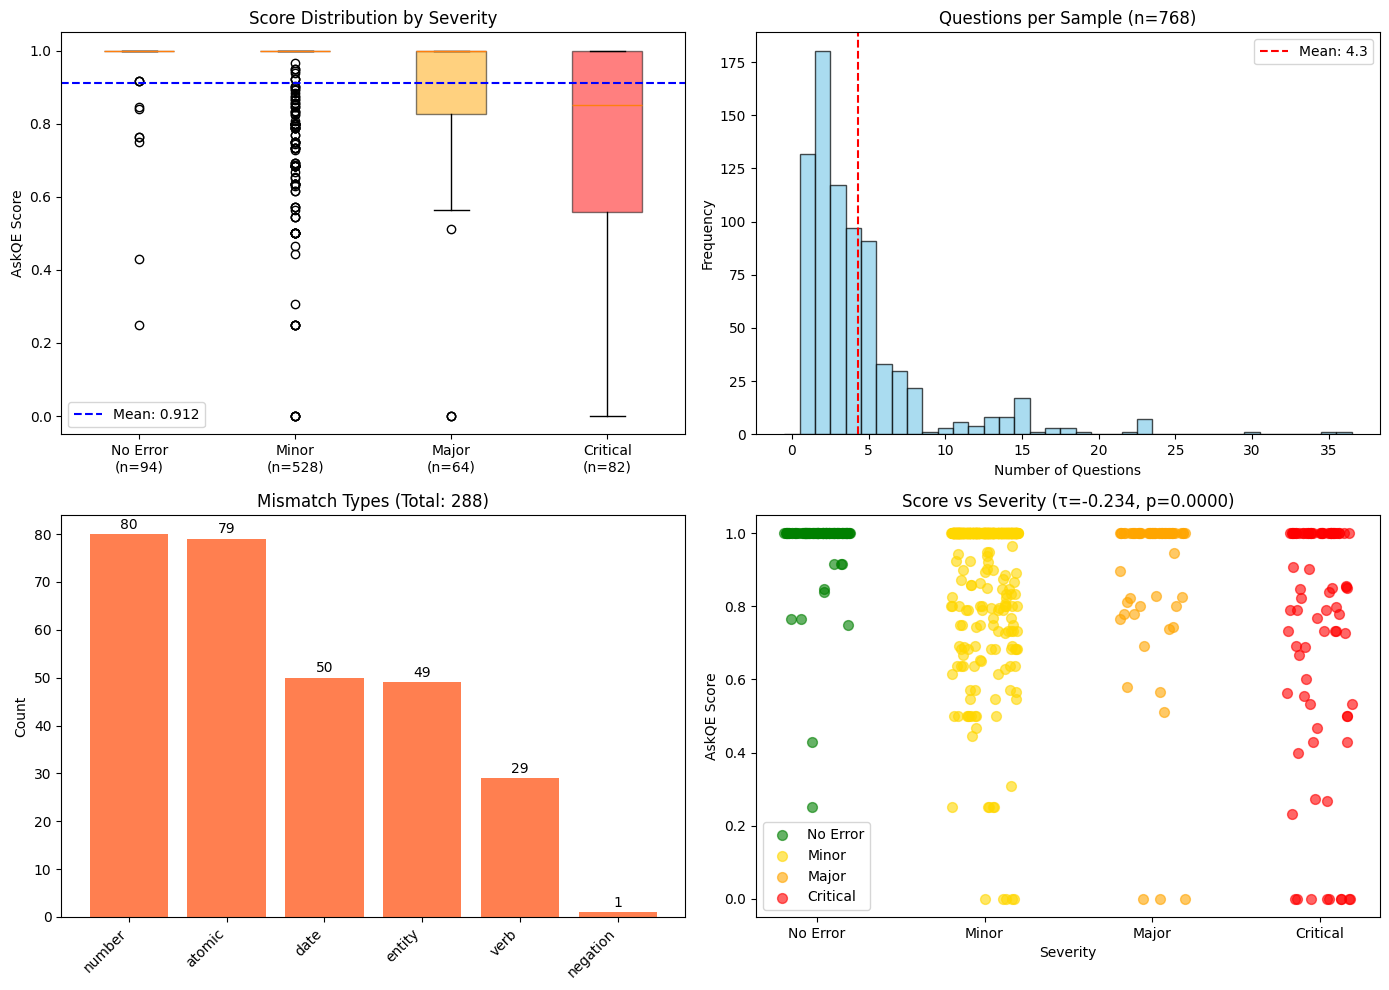


🔍 MISMATCH ANALYSIS BY SEVERITY
type      atomic  date  entity  negation  number  verb
severity                                              
Critical      20    12      20         1      17     4
Major          8     2       7         0      18     2
Minor         47    35      20         0      41    23
No Error       4     1       2         0       4     0

🔎 WORST SCORE SAMPLES

📝 ID: doc63_24 | Severity: Critical | Score: 0.000
   Questions: 2 (Template: 0, Atomic: 2)
   Mismatches: 2
   Source: Our goal is to provide the status of neoadjuvant and adjuvant treatment in MIBC....
   BT: Our aim is to provide the status of neoadjuvant and adjuvant treatment in IBC....

📝 ID: doc63_112 | Severity: Minor | Score: 0.000
   Questions: 2 (Template: 0, Atomic: 2)
   Mismatches: 2
   Source: Our goal is to provide the status of neoadjuvant and adjuvant treatment in MIBC....
   BT: Our goal is to provide the state of neoadjuvant and adjuvant treatment in the CV...

📝 ID: doc86_195 | Severit

In [40]:
import matplotlib.pyplot as plt

# Use valid data only
df_plot = df_valid.copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Score by Severity (Box Plot)
ax1 = axes[0, 0]
severity_groups = []
severity_labels = []
for sev in ["No Error", "Minor", "Major", "Critical"]:
    data = df_plot[df_plot["severity"] == sev]["askqe_score"].dropna()
    if len(data) > 0:
        severity_groups.append(data)
        severity_labels.append(f"{sev}\n(n={len(data)})")

if severity_groups:
    bp = ax1.boxplot(severity_groups, tick_labels=severity_labels, patch_artist=True)
    colors = ['green', 'yellow', 'orange', 'red']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

ax1.set_ylabel("AskQE Score")
ax1.set_title("Score Distribution by Severity")
ax1.axhline(y=df_plot["askqe_score"].mean(), color='blue', linestyle='--', label=f'Mean: {df_plot["askqe_score"].mean():.3f}')
ax1.legend()
ax1.set_ylim(-0.05, 1.05)

# 2. Questions Distribution
ax2 = axes[0, 1]
ax2.hist(df_plot["num_questions"], bins=range(0, int(df_plot["num_questions"].max())+2),
         color="skyblue", edgecolor="black", alpha=0.7, align='left')
ax2.axvline(x=df_plot["num_questions"].mean(), color='r', linestyle='--',
            label=f'Mean: {df_plot["num_questions"].mean():.1f}')
ax2.set_xlabel("Number of Questions")
ax2.set_ylabel("Frequency")
ax2.set_title(f"Questions per Sample (n={len(df_plot)})")
ax2.legend()

# 3. Mismatch Types
ax3 = axes[1, 0]
all_mismatches = []
for r in results:
    if r["askqe_score"] is not None:
        for m in r.get("mismatches", []):
            all_mismatches.append(m)

if all_mismatches:
    mismatch_df = pd.DataFrame(all_mismatches)
    mismatch_counts = mismatch_df["type"].value_counts()
    bars = ax3.bar(mismatch_counts.index, mismatch_counts.values, color="coral")
    ax3.set_title(f"Mismatch Types (Total: {len(all_mismatches)})")
    ax3.set_ylabel("Count")
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

    for bar, count in zip(bars, mismatch_counts.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom')
else:
    ax3.text(0.5, 0.5, "No mismatches found", ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title("Mismatch Types")

# 4. Score vs Severity (Scatter with jitter) - FIXED
ax4 = axes[1, 1]
severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}

# FIX: Create numeric severity as a new column properly
df_plot["severity_num"] = df_plot["severity"].astype(str).map(severity_to_num)

# Add jitter
np.random.seed(42)
jitter = np.random.uniform(-0.2, 0.2, len(df_plot))

colors_map = {"No Error": "green", "Minor": "gold", "Major": "orange", "Critical": "red"}
for sev in ["No Error", "Minor", "Major", "Critical"]:
    mask = df_plot["severity"].astype(str) == sev
    if mask.any():
        x_vals = df_plot.loc[mask, "severity_num"].values + jitter[mask.values]
        y_vals = df_plot.loc[mask, "askqe_score"].values
        ax4.scatter(x_vals, y_vals, c=colors_map[sev], label=sev, alpha=0.6, s=50)

ax4.set_xticks([0, 1, 2, 3])
ax4.set_xticklabels(["No Error", "Minor", "Major", "Critical"])
ax4.set_xlabel("Severity")
ax4.set_ylabel("AskQE Score")
ax4.set_title(f"Score vs Severity (τ={tau_sev:.3f}, p={p_tau_sev:.4f})")
ax4.legend(loc='lower left')
ax4.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

# Mismatch analysis by severity
print("\n" + "="*60)
print("🔍 MISMATCH ANALYSIS BY SEVERITY")
print("="*60)

if all_mismatches:
    mismatch_with_sev = []
    for r in results:
        if r["askqe_score"] is not None:
            for m in r.get("mismatches", []):
                m_copy = m.copy()
                m_copy["severity"] = r["severity"]
                mismatch_with_sev.append(m_copy)

    if mismatch_with_sev:
        mismatch_sev_df = pd.DataFrame(mismatch_with_sev)
        print(mismatch_sev_df.groupby(["severity", "type"]).size().unstack(fill_value=0))
else:
    print("No mismatches found")

# Worst samples
print("\n" + "="*60)
print("🔎 WORST SCORE SAMPLES")
print("="*60)

worst = df_valid.nsmallest(5, "askqe_score")
for _, row in worst.iterrows():
    print(f"\n📝 ID: {row['id']} | Severity: {row['severity']} | Score: {row['askqe_score']:.3f}")
    print(f"   Questions: {row['num_questions']} (Template: {row['num_template_qs']}, Atomic: {row['num_atomic_qs']})")
    print(f"   Mismatches: {row['num_mismatches']}")
    print(f"   Source: {row['source'][:80]}...")
    print(f"   BT: {row['backtranslation'][:80]}...")

##Additional Metrics

In [41]:
from scipy.stats import pearsonr, kendalltau, spearmanr
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

print("="*60)
print("📊 COMPREHENSIVE METRICS ANALYSIS")
print("="*60)

# Use valid data
df_metrics = df_valid.copy()

# Create numeric severity
severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}
df_metrics["severity_num"] = df_metrics["severity"].astype(str).map(severity_to_num)

# Create MQM-style score (higher = better)
mqm_map = {"No Error": 100, "Minor": 99, "Major": 95, "Critical": 75}
df_metrics["mqm_score"] = df_metrics["severity"].astype(str).map(mqm_map)

# ============================================
# 1. ALL CORRELATION METRICS
# ============================================
print("\n" + "-"*60)
print("1️⃣ CORRELATION METRICS")
print("-"*60)

# vs Severity (higher severity = worse)
tau_sev, p_tau = kendalltau(df_metrics["severity_num"], df_metrics["askqe_score"])
rho_sev, p_rho = spearmanr(df_metrics["severity_num"], df_metrics["askqe_score"])
pear_sev, p_pear = pearsonr(df_metrics["severity_num"], df_metrics["askqe_score"])

print(f"\nCorrelation with Severity (expected: NEGATIVE)")
print(f"   Kendall's τ:  {tau_sev:.4f} (p={p_tau:.2e})")
print(f"   Spearman ρ:   {rho_sev:.4f} (p={p_rho:.2e})")
print(f"   Pearson r:    {pear_sev:.4f} (p={p_pear:.2e})")

# vs MQM Score (higher MQM = better quality = higher askqe expected)
tau_mqm, p_tau_m = kendalltau(df_metrics["mqm_score"], df_metrics["askqe_score"])
rho_mqm, p_rho_m = spearmanr(df_metrics["mqm_score"], df_metrics["askqe_score"])
pear_mqm, p_pear_m = pearsonr(df_metrics["mqm_score"], df_metrics["askqe_score"])

print(f"\nCorrelation with MQM Score (expected: POSITIVE)")
print(f"   Kendall's τ:  {tau_mqm:.4f} (p={p_tau_m:.2e})")
print(f"   Spearman ρ:   {rho_mqm:.4f} (p={p_rho_m:.2e})")
print(f"   Pearson r:    {pear_mqm:.4f} (p={p_pear_m:.2e})")

# ============================================
# 2. DECISION ACCURACY (GMM-based, like Paper)
# ============================================
print("\n" + "-"*60)
print("2️⃣ DECISION ACCURACY (GMM-based)")
print("-"*60)

# Ground truth: Accept = No Error/Minor, Reject = Major/Critical
df_metrics["human_decision"] = df_metrics["severity"].astype(str).apply(
    lambda x: 1 if x in ["No Error", "Minor"] else 0  # 1=Accept, 0=Reject
)

# GMM clustering
X = df_metrics["askqe_score"].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)

# Identify Accept cluster (higher mean score)
means = gmm.means_.flatten()
accept_label = np.argmax(means)
df_metrics["predicted_decision"] = (labels == accept_label).astype(int)

# Calculate accuracy
decision_accuracy = accuracy_score(df_metrics["human_decision"], df_metrics["predicted_decision"])
print(f"\nGMM Decision Accuracy: {decision_accuracy*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(df_metrics["human_decision"], df_metrics["predicted_decision"])
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Reject  Accept")
print(f"   Actual Reject   {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"   Actual Accept   {cm[1,0]:4d}    {cm[1,1]:4d}")

# ============================================
# 3. BINARY CLASSIFICATION METRICS
# ============================================
print("\n" + "-"*60)
print("3️⃣ BINARY CLASSIFICATION (Error Detection)")
print("-"*60)

# Binary: Has Error (Major/Critical) vs No/Minor Error
df_metrics["has_serious_error"] = df_metrics["severity"].astype(str).apply(
    lambda x: 1 if x in ["Major", "Critical"] else 0
)

# Find optimal threshold
thresholds = np.arange(0.5, 1.0, 0.05)
best_f1 = 0
best_threshold = 0.5

for thresh in thresholds:
    pred = (df_metrics["askqe_score"] < thresh).astype(int)  # Low score = error
    f1 = f1_score(df_metrics["has_serious_error"], pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"\nOptimal Threshold: {best_threshold:.2f}")
print(f"(Scores below this indicate Major/Critical error)")

# Predictions with optimal threshold
df_metrics["predicted_error"] = (df_metrics["askqe_score"] < best_threshold).astype(int)

precision = precision_score(df_metrics["has_serious_error"], df_metrics["predicted_error"], zero_division=0)
recall = recall_score(df_metrics["has_serious_error"], df_metrics["predicted_error"], zero_division=0)
f1 = f1_score(df_metrics["has_serious_error"], df_metrics["predicted_error"], zero_division=0)

print(f"\nError Detection Performance:")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

# ROC-AUC (using inverted score since low score = error)
try:
    auc = roc_auc_score(df_metrics["has_serious_error"], 1 - df_metrics["askqe_score"])
    print(f"   ROC-AUC:   {auc:.4f}")
except:
    print(f"   ROC-AUC:   N/A")

# ============================================
# 4. PER-SEVERITY ANALYSIS
# ============================================
print("\n" + "-"*60)
print("4️⃣ PER-SEVERITY DETECTION RATE")
print("-"*60)

for sev in ["No Error", "Minor", "Major", "Critical"]:
    sev_data = df_metrics[df_metrics["severity"].astype(str) == sev]
    if len(sev_data) > 0:
        detected = (sev_data["askqe_score"] < best_threshold).sum()
        total = len(sev_data)
        rate = detected / total * 100
        print(f"   {sev:12s}: {detected:3d}/{total:3d} detected ({rate:5.1f}%)")

# ============================================
# 5. COMPARISON SUMMARY
# ============================================
print("\n" + "="*60)
print("📈 COMPARISON WITH BASELINE")
print("="*60)

print(f"""
┌────────────────────────────────────────────────────────────┐
│                    METRIC COMPARISON                        │
├────────────────────────────────────────────────────────────┤
│ Metric              │ Baseline │ Ours     │ Improvement    │
├────────────────────────────────────────────────────────────┤
│ Kendall τ (vs MQM)  │  0.109   │  {abs(tau_mqm):.3f}    │  {(abs(tau_mqm)/0.109-1)*100:+.0f}%           │
│ Spearman ρ (vs MQM) │  ~0.12   │  {abs(rho_mqm):.3f}    │  {(abs(rho_mqm)/0.12-1)*100:+.0f}%           │
│ Decision Accuracy   │  ~50%    │  {decision_accuracy*100:.1f}%   │  {(decision_accuracy-0.5)*100:+.0f}pp          │
│ Error Detection F1  │   N/A    │  {f1:.3f}    │    N/A         │
└────────────────────────────────────────────────────────────┘
""")

📊 COMPREHENSIVE METRICS ANALYSIS

------------------------------------------------------------
1️⃣ CORRELATION METRICS
------------------------------------------------------------

Correlation with Severity (expected: NEGATIVE)
   Kendall's τ:  -0.2345 (p=4.37e-13)
   Spearman ρ:   -0.2609 (p=2.04e-13)
   Pearson r:    -0.2982 (p=3.08e-17)

Correlation with MQM Score (expected: POSITIVE)
   Kendall's τ:  0.2345 (p=4.37e-13)
   Spearman ρ:   0.2609 (p=2.04e-13)
   Pearson r:    0.3090 (p=1.88e-18)

------------------------------------------------------------
2️⃣ DECISION ACCURACY (GMM-based)
------------------------------------------------------------

GMM Decision Accuracy: 73.70%

Confusion Matrix:
                 Predicted
                 Reject  Accept
   Actual Reject     66      80
   Actual Accept    122     500

------------------------------------------------------------
3️⃣ BINARY CLASSIFICATION (Error Detection)
------------------------------------------------------------



##Save Results

In [ ]:
# Save to JSON
output_file = "extension_results.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)
print(f"✅ Results saved to {output_file}")

# Save summary to CSV
summary_df = df[["row_id", "id", "severity", "mqm_score", "num_questions", "num_mismatches", "askqe_score"]]
summary_df.to_csv("extension_summary.csv", index=False)
print(f"✅ Summary saved to extension_summary.csv")

# Final Summary
print("\n" + "="*60)
print("📋 FINAL SUMMARY")
print("="*60)
print(f"""
Extension Pipeline Results:
- Total Samples: {len(df)}
- Mean AskQE Score: {df['askqe_score'].mean():.3f}
- Samples with Errors Detected: {len(errors_df)} ({100*len(errors_df)/len(df):.1f}%)
- Avg Questions/Sample: {df['num_questions'].mean():.1f}
- Correlation (Kendall Tau): {tau:.4f}

Top Mismatch Types:
{mismatch_df['type'].value_counts().head(3).to_string() if all_mismatches else 'None'}
""")

In [23]:
# ============================================
# 🔍 DEBUG: Check for Bias
# ============================================

print("📊 BIAS CHECK")
print("="*60)

# 1. Zero-question samples
zero_q = df[df["num_questions"] == 0]
print(f"\n1. Zero-question samples: {len(zero_q)}")
print(f"   Their scores: {zero_q['askqe_score'].unique()}")
print(f"   By severity: {zero_q['severity'].value_counts().to_dict()}")

# 2. Perfect score samples
perfect = df[df["askqe_score"] == 1.0]
print(f"\n2. Perfect score (1.0) samples: {len(perfect)} ({100*len(perfect)/len(df):.1f}%)")
print(f"   By severity: {perfect['severity'].value_counts().to_dict()}")

# 3. Samples with at least 1 question
with_questions = df[df["num_questions"] > 0]
print(f"\n3. Samples WITH questions: {len(with_questions)}")

# Recalculate correlation only for samples with questions
from scipy.stats import kendalltau
severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}
with_questions["severity_num"] = with_questions["severity"].map(severity_to_num)
tau, p = kendalltau(with_questions["severity_num"], with_questions["askqe_score"])
print(f"   Kendall's Tau (only with questions): {tau:.4f} (p={p:.4e})")

# 4. Score distribution
print(f"\n4. Score distribution:")
print(f"   Score = 1.0: {len(df[df['askqe_score'] == 1.0])}")
print(f"   Score < 1.0: {len(df[df['askqe_score'] < 1.0])}")
print(f"   Score < 0.5: {len(df[df['askqe_score'] < 0.5])}")

📊 BIAS CHECK

1. Zero-question samples: 14
   Their scores: [1.]
   By severity: {'Minor': 11, 'No Error': 2, 'Critical': 1, 'Major': 0}

2. Perfect score (1.0) samples: 80 (80.0%)
   By severity: {'Minor': 53, 'No Error': 11, 'Critical': 9, 'Major': 7}

3. Samples WITH questions: 86
   Kendall's Tau (only with questions): -0.2778 (p=3.9933e-03)

4. Score distribution:
   Score = 1.0: 80
   Score < 1.0: 20
   Score < 0.5: 5


/tmp/ipython-input-4123778778.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_questions["severity_num"] = with_questions["severity"].map(severity_to_num)
